# Clustering

Problems:




In [1]:
# Useful starting lines
%matplotlib inline
import copy
#import matplotlib as mpl
import datetime as dt

import re
import glob
import ast
from datetime import datetime
from collections import Counter
import itertools
import nltk
nltk.download("stopwords")
from nltk import bigrams 
from nltk.corpus import stopwords
import string
import locale
import reverse_geocoder as rg
import dask.dataframe as dd
locale.setlocale(locale.LC_TIME, "en_US.utf8")
%load_ext autoreload

[nltk_data] Downloading package stopwords to /home/servan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#packages to manipulate data structures
import pandas as pd
from sklearn.utils import shuffle
import numpy as np 
from sklearn import preprocessing
import scipy.sparse as sps
import itertools
from copy import deepcopy

#packages for machine learning model
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import ward_tree
from sklearn.preprocessing import scale
from imblearn.over_sampling import RandomOverSampler

#packages for parallelisation
from joblib import Parallel, delayed
import multiprocessing as mp
import heapq

#packages for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pygraphviz
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import shapely

#packages for file manipulation & saving
import pickle

#packages for performance tracking
import time

In [5]:
sent2vec_path =    "/mount/SDF/TweetDumpBalanced/sent2vec_pkl/"
coord_state_path = "/mount/SDF/TweetDumpBalanced/coord_state/"

y_start = pd.read_pickle(coord_state_path+"tw50_74coord_states.pkl")
x_start = pd.read_pickle(sent2vec_path+"sent2vectw50_74.pkl")
x_start = x_start.loc[:,0:699]

In [6]:

#y_start = y_start.loc[:,1]

In [129]:
subset = len(y_start)

In [130]:
Y = y_start.loc[0:subset]
X = x_start.loc[0:subset,0:699]
#X,Y = shuffle(X,Y,random_state=2)

In [131]:
Y

coord                 state
0                 [39.2904, -76.6122]              Maryland
1         [41.12643843, -73.42110322]           Connecticut
2           [32.150881, -111.0040186]               Arizona
3         [30.47115735, -84.23093587]               Florida
4           [44.95198794, -70.638263]                 Maine
5          [42.4845171, -83.24758172]              Michigan
6         [33.08592323, -97.29607799]                 Texas
7         [40.82734347, -96.60660183]              Nebraska
8        [44.65320015, -103.85730457]          South Dakota
9         [33.74315061, -84.51172603]               Georgia
10        [39.28536616, -75.62223261]              Delaware
11        [38.86380434, -77.06063747]  District of Columbia
12        [43.17044558, -73.05684649]               Vermont
13         [38.8731935, -77.00180054]  District of Columbia
14       [43.15102559, -115.69521384]                 Idaho
15            [32.678208, -83.178297]               Georgia
16        [42.72639557, -71.44896146]         New Hampshire
17        [32.49566773, -92.07842203]             Louisiana
18          [39.5612825, -95.1746785]                Kansas
19        [44.33800101, -70.37526258]                 Maine
20            [27.995287, -81.160783]               Florida
21       [32.63980333, -114.54574481]               Arizona
22       [39.11911618, -100.81101576]                Kansas
23        [32.59654522, -80.74772369]        South Carolina
24          [42.7890651, -71.2152339]         New Hampshire
25        [41.46700063, -73.01852592]           Connecticut
26        [35.69666441, -81.30526015]        North Carolina
27        [42.05762627, -95.41889026]                  Iowa
28       [43.87596339, -103.45430374]          South Dakota
29        [39.38543451, -77.91804976]         West Virginia
...                               ...                   ...
2842403   [42.46961801, -83.12525746]              Michigan
2842404   [48.73191495, -122.5020647]            Washington
2842405   [45.09507841, -93.33956556]             Minnesota
2842406     [25.4536488, -80.4097555]               Florida
2842407   [40.52043628, -79.83937277]          Pennsylvania
2842408     [41.8537084, -71.4455128]          Rhode Island
2842409   [38.35173161, -75.59343072]              Maryland
2842410       [29.250073, -81.066847]               Florida
2842411   [43.93413375, -70.89240187]                 Maine
2842412   [43.89478447, -70.11870507]                 Maine
2842413   [39.73720064, -75.55129845]              Delaware
2842414   [42.27448743, -83.73080933]              Michigan
2842415  [39.60492224, -105.95388573]              Colorado
2842416   [46.86421271, -96.84535752]          North Dakota
2842417    [34.1662325, -106.0260685]            New Mexico
2842418    [42.8680335, -112.4999045]                 Idaho
2842419    [43.5967622, -72.96864138]               Vermont
2842420    [36.11786907, -94.0538078]              Arkansas
2842421     [39.4413743, -75.7546218]              Delaware
2842422   [33.69936472, -84.09414509]               Georgia
2842423    [41.75331879, -86.1395874]               Indiana
2842424   [44.47537217, -73.21308755]               Vermont
2842425   [42.09995435, -86.45865415]              Michigan
2842426      [41.147444, -104.769001]               Wyoming
2842427   [33.95689823, -83.37897659]               Georgia
2842428   [29.64860542, -82.35061377]               Florida
2842429      [36.001827, -78.9011455]        North Carolina
2842430  [36.11024084, -115.16779511]                Nevada
2842431   [38.91090471, -77.04439402]      Washington, D.C.
2842432  [47.82777778, -116.84194444]                 Idaho

[2842433 rows x 2 columns]

In [9]:
states_dict = {
#        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        #'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DC1':'Washington, D.C.',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
#        'GU': 'Guam',
#        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        #'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        #'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        #'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

#linguistic regions: https://www.washingtonpost.com/blogs/govbeat/wp/2013/12/02/what-dialect-to-do-you-speak-a-map-of-american-english/?utm_term=.1156615c2e39
lingo_regions = {"West": ("Washington","Oregon","California","Idaho",
                "Montana","Nevada","Arizona","Utah","Wyoming","North Dakota",
                "South Dakota","Nebraska","Kansas","Oklahoma","Colorado",
                "New Mexico","Texas","Missouri","Iowa"),
                "UpperNorth": ("Minnesota","Wisconsin","Michigan","New York",
                "Massachusetts","Vermont","New Hampshire","Maine","Rhode Island",
                "Connecticut"),
                "LowerNorth": ("Pennsylvania","New Jersey","Ohio","Indiana","Illinois"),
                "UpperSouth": ("Delaware","Maryland","Washington, D.C.","West Virginia",
                "Kentucky","Tennessee"),
                "LowerSouth": ("Virginia","North Carolina","South Carolina","Georgia",
                "Florida","Alabama","Mississippi","Louisiana","Arkansas")}


In [132]:
Y.loc[Y["state"]=="Washington, D.C.","state"] = "District of Columbia"
states = np.unique(Y["state"])

In [133]:
X = scale(X)

In [20]:
print(np.mean(X,axis=0))
print(np.var(X,axis=0))

[ -2.84209989e-18  -1.13683996e-17  -7.10524973e-18  -6.39472475e-18
  -1.13683996e-17   4.26314984e-18   7.10524973e-19   2.34473241e-17
   3.48157237e-17   1.01249809e-17   4.26314984e-18   1.98946992e-17
   1.70525993e-17   8.88156216e-18   2.13157492e-18  -8.52629967e-18
   0.00000000e+00   5.68419978e-18   7.81577470e-18   3.12630988e-17
   7.46051221e-18  -1.20789245e-17   2.98420489e-17  -1.20789245e-17
   1.84736493e-17  -2.52236365e-17  -5.68419978e-18  -1.42104995e-18
   4.26314984e-18  -1.13683996e-17  -1.84736493e-17   4.26314984e-18
   6.60788225e-17  -1.42104995e-18   4.97367481e-18  -1.27894495e-17
   1.79407556e-17  -2.84209989e-17  -2.29144304e-17  -1.20789245e-16
  -3.55262486e-17   4.83156981e-17   5.54209479e-17  -2.84209989e-18
   7.46051221e-18   1.84736493e-17  -2.55788990e-17  -1.06578746e-18
  -1.91841743e-17   1.77631243e-18   3.26841487e-17  -1.88289118e-17
   2.43354803e-17  -3.41051987e-17  -3.71249298e-17  -5.96840977e-17
  -1.98946992e-17  -7.10524973e-18

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [134]:
my_tab = pd.crosstab(index=Y["state"],  # Make a crosstab
                              columns="count")
print(my_tab)
print(len(Y))

col_0                 count
state                      
Alabama               58029
Arizona               57987
Arkansas              58046
California            58004
Colorado              57993
Connecticut           58035
Delaware              58035
District of Columbia  58043
Florida               58027
Georgia               58023
Idaho                 57966
Illinois              58029
Indiana               58034
Iowa                  57986
Kansas                57999
Kentucky              57998
Louisiana             58049
Maine                 57991
Maryland              58055
Massachusetts         58012
Michigan              58023
Minnesota             58000
Mississippi           58065
Missouri              58016
Montana               57942
Nebraska              58000
Nevada                58020
New Hampshire         57990
New Jersey            58011
New Mexico            57987
New York              58019
North Carolina        58042
North Dakota          57970
Ohio                

## MiniBatch k-means

In [135]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
n_clusts = [500,2500,5000,10000]#,400,600,800,1000,1500,2000,2500,3000]
models = []
labels = []
Y1_vecs = []
for i in n_clusts:
    print("Find "+str(i)+" clusters...")
    start_time = time.time()
    cluster_model = MiniBatchKMeans(n_clusters=i,max_iter=100,batch_size=5000,
                               verbose=0,compute_labels=True,
                               random_state=10)
    #cluster_model = DBSCAN(eps=0.5, min_samples=5, metric="cosine", 
    #                       metric_params=None, algorithm="brute", leaf_size=30, p=None, n_jobs=8)
    models.append(cluster_model)
    cluster_model.fit(X)
    label = pd.Series(cluster_model.labels_)
    labels.append(label)
    Y1 = pd.concat([Y["state"],label],1)
    Y1.columns = ["state","cluster"]
    Y1_vecs.append(Y1)
    elapsed_time = time.time() - start_time
    print("...Done in: "+str(elapsed_time)+"s")
    


Find 500 clusters...
...Done in: 111.78166198730469s
Find 2500 clusters...
...Done in: 294.1546573638916s
Find 5000 clusters...
...Done in: 919.6665933132172s
Find 10000 clusters...
...Done in: 1537.9455926418304s


In [136]:
with open("cluster_models_2.8mio.pkl", "wb") as f:
    for model in models:
         pickle.dump(model, f)

with open("cluster_results_2.8mio.pkl", "wb") as f:
    for Y1 in Y1_vecs:
         pickle.dump(Y1, f)

In [94]:
models = []
with open("cluster_models.pkl", "rb") as f:
    while True:
        try:
            models.append(pickle.load(f))
        except EOFError:
            break

Y1_vecs = []
with open("cluster_results.pkl", "rb") as f:
    while True:
        try:
            Y1_vecs.append(pickle.load(f))
        except EOFError:
            break

In [138]:
Y1_vecs[3]

state  cluster
0                    Maryland       45
1                 Connecticut     4747
2                     Arizona     1464
3                     Florida     9441
4                       Maine     7835
5                    Michigan     6158
6                       Texas     7443
7                    Nebraska     3730
8                South Dakota     8965
9                     Georgia     1493
10                   Delaware     9799
11       District of Columbia     8884
12                    Vermont     1800
13       District of Columbia      650
14                      Idaho      994
15                    Georgia     1869
16              New Hampshire     1799
17                  Louisiana     7083
18                     Kansas      708
19                      Maine     3779
20                    Florida     6077
21                    Arizona     6853
22                     Kansas     7971
23             South Carolina     3621
24              New Hampshire     1558
25                Connecticut      837
26             North Carolina     1288
27                       Iowa     5550
28               South Dakota     1464
29              West Virginia     2996
...                       ...      ...
2842404            Washington     3231
2842405             Minnesota     4829
2842406               Florida     1424
2842407          Pennsylvania     3787
2842408          Rhode Island     2722
2842409              Maryland     4407
2842410               Florida     8514
2842411                 Maine     7913
2842412                 Maine     1296
2842413              Delaware     4657
2842414              Michigan     3150
2842415              Colorado     8543
2842416          North Dakota        1
2842417            New Mexico     1296
2842418                 Idaho     6431
2842419               Vermont       45
2842420              Arkansas     5249
2842421              Delaware      510
2842422               Georgia      175
2842423               Indiana     9630
2842424               Vermont     2926
2842425              Michigan     6531
2842426               Wyoming     6815
2842427               Georgia     5918
2842428               Florida     5042
2842429        North Carolina      267
2842430                Nevada     9446
2842431  District of Columbia     6714
2842432                 Idaho     8631
2842433                   NaN      846

[2842434 rows x 2 columns]

In [139]:
Y_tab = Y1_vecs[3]
current_model = models[3]

In [356]:
current_model

MiniBatchKMeans(batch_size=5000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=200, n_init=3, random_state=10, reassignment_ratio=0.01,
        tol=0.0, verbose=0)

In [140]:
cluster_given_state = pd.crosstab(index=Y_tab.loc[:,"state"],columns=Y_tab.loc[:,"cluster"],normalize="index")

In [141]:
state_given_cluster = pd.crosstab(index=Y_tab.loc[:,"state"],columns=Y_tab.loc[:,"cluster"],normalize="columns")

In [142]:
cluster_given_state

cluster                   0         1         2         3         5     \
state                                                                    
Alabama               0.000000  0.000396  0.000000  0.000000  0.000017   
Arizona               0.000000  0.000414  0.000052  0.000000  0.000017   
Arkansas              0.000000  0.000379  0.000000  0.000000  0.000000   
California            0.000000  0.000465  0.000000  0.000000  0.000017   
Colorado              0.000000  0.000241  0.000017  0.000000  0.000000   
Connecticut           0.000000  0.000482  0.000034  0.000000  0.000000   
Delaware              0.000000  0.000396  0.000000  0.000000  0.000017   
District of Columbia  0.000000  0.000362  0.000017  0.000000  0.000017   
Florida               0.000017  0.000448  0.000017  0.000017  0.000017   
Georgia               0.000000  0.000345  0.000000  0.000000  0.000034   
Idaho                 0.000000  0.000242  0.000017  0.000000  0.000017   
Illinois              0.000000  0.000293  0.000000  0.000000  0.000017   
Indiana               0.000000  0.000603  0.000000  0.000000  0.000017   
Iowa                  0.000000  0.000379  0.000034  0.000000  0.000017   
Kansas                0.000000  0.000259  0.000017  0.000000  0.000000   
Kentucky              0.000000  0.000379  0.000017  0.000000  0.000000   
Louisiana             0.000017  0.000603  0.000034  0.000000  0.000000   
Maine                 0.000000  0.000483  0.000000  0.000000  0.000000   
Maryland              0.000000  0.000431  0.000017  0.000000  0.000000   
Massachusetts         0.000000  0.000310  0.000017  0.000000  0.000017   
Michigan              0.000000  0.000259  0.000000  0.000000  0.000000   
Minnesota             0.000000  0.000397  0.000017  0.000000  0.000017   
Mississippi           0.000017  0.000172  0.000000  0.000017  0.000000   
Missouri              0.000000  0.000379  0.000017  0.000000  0.000000   
Montana               0.000000  0.000362  0.000000  0.000017  0.000000   
Nebraska              0.000000  0.000483  0.000000  0.000034  0.000034   
Nevada                0.000000  0.000379  0.000017  0.000000  0.000034   
New Hampshire         0.000017  0.000379  0.000017  0.000000  0.000052   
New Jersey            0.000000  0.000517  0.000000  0.000000  0.000000   
New Mexico            0.000000  0.000259  0.000034  0.000000  0.000017   
New York              0.000000  0.000207  0.000069  0.000000  0.000017   
North Carolina        0.000000  0.000258  0.000017  0.000000  0.000000   
North Dakota          0.000000  0.000242  0.000000  0.000000  0.000000   
Ohio                  0.000000  0.000517  0.000034  0.000000  0.000034   
Oklahoma              0.000000  0.000397  0.000000  0.000000  0.000000   
Oregon                0.000000  0.000362  0.000000  0.000000  0.000017   
Pennsylvania          0.000000  0.000431  0.000052  0.000000  0.000017   
Rhode Island          0.000000  0.000259  0.000017  0.000000  0.000000   
South Carolina        0.000000  0.000431  0.000017  0.000000  0.000000   
South Dakota          0.000000  0.000276  0.000000  0.000000  0.000017   
Tennessee             0.000000  0.000396  0.000017  0.000000  0.000000   
Texas                 0.000000  0.000345  0.000017  0.000000  0.000000   
Utah                  0.000000  0.000328  0.000000  0.000000  0.000000   
Vermont               0.000000  0.000380  0.000017  0.000017  0.000017   
Virginia              0.000000  0.000276  0.000034  0.000017  0.000000   
Washington            0.000000  0.000448  0.000017  0.000000  0.000000   
West Virginia         0.000000  0.000396  0.000069  0.000000  0.000000   
Wisconsin             0.000000  0.000483  0.000000  0.000000  0.000000   
Wyoming               0.000000  0.000501  0.000000  0.000000  0.000000   

cluster                   6         7         8         10        11    \
state                                                                    
Alabama               0.000000  0.000052  0.000086  0.000000  0.000086   
Ari

In [143]:
state_given_cluster

cluster               0         1         2         3         5         6     \
state                                                                          
Alabama               0.00  0.021515  0.000000  0.000000  0.034483  0.000000   
Arizona               0.00  0.022451  0.066667  0.000000  0.034483  0.000000   
Arkansas              0.00  0.020580  0.000000  0.000000  0.000000  0.000000   
California            0.00  0.025257  0.000000  0.000000  0.034483  0.000000   
Colorado              0.00  0.013096  0.022222  0.000000  0.000000  0.333333   
Connecticut           0.00  0.026193  0.044444  0.000000  0.000000  0.000000   
Delaware              0.00  0.021515  0.000000  0.000000  0.034483  0.000000   
District of Columbia  0.00  0.019645  0.022222  0.000000  0.034483  0.000000   
Florida               0.25  0.024322  0.022222  0.142857  0.034483  0.000000   
Georgia               0.00  0.018709  0.000000  0.000000  0.068966  0.000000   
Idaho                 0.00  0.013096  0.022222  0.000000  0.034483  0.000000   
Illinois              0.00  0.015903  0.000000  0.000000  0.034483  0.000000   
Indiana               0.00  0.032741  0.000000  0.000000  0.034483  0.000000   
Iowa                  0.00  0.020580  0.044444  0.000000  0.034483  0.000000   
Kansas                0.00  0.014032  0.022222  0.000000  0.000000  0.000000   
Kentucky              0.00  0.020580  0.022222  0.000000  0.000000  0.000000   
Louisiana             0.25  0.032741  0.044444  0.000000  0.000000  0.000000   
Maine                 0.00  0.026193  0.000000  0.000000  0.000000  0.000000   
Maryland              0.00  0.023386  0.022222  0.000000  0.000000  0.333333   
Massachusetts         0.00  0.016838  0.022222  0.000000  0.034483  0.000000   
Michigan              0.00  0.014032  0.000000  0.000000  0.000000  0.000000   
Minnesota             0.00  0.021515  0.022222  0.000000  0.034483  0.000000   
Mississippi           0.25  0.009355  0.000000  0.142857  0.000000  0.000000   
Missouri              0.00  0.020580  0.022222  0.000000  0.000000  0.333333   
Montana               0.00  0.019645  0.000000  0.142857  0.000000  0.000000   
Nebraska              0.00  0.026193  0.000000  0.285714  0.068966  0.000000   
Nevada                0.00  0.020580  0.022222  0.000000  0.068966  0.000000   
New Hampshire         0.25  0.020580  0.022222  0.000000  0.103448  0.000000   
New Jersey            0.00  0.028064  0.000000  0.000000  0.000000  0.000000   
New Mexico            0.00  0.014032  0.044444  0.000000  0.034483  0.000000   
New York              0.00  0.011225  0.088889  0.000000  0.034483  0.000000   
North Carolina        0.00  0.014032  0.022222  0.000000  0.000000  0.000000   
North Dakota          0.00  0.013096  0.000000  0.000000  0.000000  0.000000   
Ohio                  0.00  0.028064  0.044444  0.000000  0.068966  0.000000   
Oklahoma              0.00  0.021515  0.000000  0.000000  0.000000  0.000000   
Oregon                0.00  0.019645  0.000000  0.000000  0.034483  0.000000   
Pennsylvania          0.00  0.023386  0.066667  0.000000  0.034483  0.000000   
Rhode Island          0.00  0.014032  0.022222  0.000000  0.000000  0.000000   
South Carolina        0.00  0.023386  0.022222  0.000000  0.000000  0.000000   
South Dakota          0.00  0.014967  0.000000  0.000000  0.034483  0.000000   
Tennessee             0.00  0.021515  0.022222  0.000000  0.000000  0.000000   
Texas                 0.00  0.018709  0.022222  0.000000  0.000000  0.000000   
Utah                  0.00  0.017774  0.000000  0.000000  0.000000  0.000000   
Vermont               0.00  0.020580  0.022222  0.142857  0.034483  0.000000   
Virginia              0.00  0.014967  0.044444  0.142857  0.000000  0.000000   
Washington            0.00  0.024322  0.022222  0.000000  0.000000  0.000000   
West Virginia         0.00  0.021515  0.088889  0.000000  0.000000  0.000000   
Wisconsin             0.00  0.026193  0.000000  0.000000  0.000000  0.000000   


In [183]:
X_test = X[0:10000,]
Y_test = Y[0:10000]

In [184]:
cluster_pred = pd.Series(current_model.predict(X_test))

In [185]:
def cluster_lookup(x):
    states = state_given_cluster.loc[:,x]
    state = states.nlargest(1).index.values
    return(state)

In [186]:
predicted = cluster_pred.apply(cluster_lookup)

In [187]:
sum([Y_test.loc[i,"state"] in predicted.loc[i] for i in range(0,len(predicted))])

322

In [96]:
zip(predicted,Y_test)

TypeError: 'zip' object is not subscriptable

In [92]:
np.where(np.array(predicted)==np.array(Y_test))

/home/servan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

In [78]:
Y_test

coord                 state
0            [39.2904, -76.6122]              Maryland
1    [41.12643843, -73.42110322]           Connecticut
2      [32.150881, -111.0040186]               Arizona
3    [30.47115735, -84.23093587]               Florida
4      [44.95198794, -70.638263]                 Maine
5     [42.4845171, -83.24758172]              Michigan
6    [33.08592323, -97.29607799]                 Texas
7    [40.82734347, -96.60660183]              Nebraska
8   [44.65320015, -103.85730457]          South Dakota
9    [33.74315061, -84.51172603]               Georgia
10   [39.28536616, -75.62223261]              Delaware
11   [38.86380434, -77.06063747]  District of Columbia
12   [43.17044558, -73.05684649]               Vermont
13    [38.8731935, -77.00180054]  District of Columbia
14  [43.15102559, -115.69521384]                 Idaho
15       [32.678208, -83.178297]               Georgia
16   [42.72639557, -71.44896146]         New Hampshire
17   [32.49566773, -92.07842203]             Louisiana
18     [39.5612825, -95.1746785]                Kansas
19   [44.33800101, -70.37526258]                 Maine
20       [27.995287, -81.160783]               Florida
21  [32.63980333, -114.54574481]               Arizona
22  [39.11911618, -100.81101576]                Kansas
23   [32.59654522, -80.74772369]        South Carolina
24     [42.7890651, -71.2152339]         New Hampshire
25   [41.46700063, -73.01852592]           Connecticut
26   [35.69666441, -81.30526015]        North Carolina
27   [42.05762627, -95.41889026]                  Iowa
28  [43.87596339, -103.45430374]          South Dakota
29   [39.38543451, -77.91804976]         West Virginia
..                           ...                   ...
70   [36.21366736, -86.81202477]             Tennessee
71   [35.2073161, -106.72621107]            New Mexico
72     [39.1827539, -96.5567384]                Kansas
73      [47.672799, -117.412346]            Washington
74    [33.3498258, -111.8511017]               Arizona
75   [40.21686779, -76.89585848]          Pennsylvania
76    [34.5429039, -86.99755668]               Alabama
77    [47.04552352, -67.7353238]                 Maine
78   [41.24014225, -95.95204873]              Nebraska
79   [41.86256199, -71.40001366]          Rhode Island
80        [42.33992, -71.166069]         Massachusetts
81   [41.58902974, -93.65610394]                  Iowa
82     [42.5746999, -90.2270111]             Wisconsin
83   [42.95925985, -71.21645884]         New Hampshire
84     [37.8424907, -96.8631799]                Kansas
85     [32.8016402, -79.8764235]        South Carolina
86   [39.01228855, -75.59274449]              Delaware
87  [32.32918255, -106.79472232]            New Mexico
88    [41.1626997, -104.6182182]               Wyoming
89   [40.41513941, -80.55447288]         West Virginia
90   [33.61101732, -88.65274586]           Mississippi
91  [41.11417332, -104.82192102]               Wyoming
92     [38.0019781, -84.4141738]              Kentucky
93    [31.54288601, -93.4589084]             Louisiana
94    [33.8624053, -84.24093045]               Georgia
95   [41.97995335, -71.47401737]          Rhode Island
96  [40.39714011, -104.76592529]              Colorado
97   [39.04915473, -76.92437975]              Maryland
98   [41.75067515, -71.45144817]          Rhode Island
99   [45.56914684, -94.22106504]             Minnesota

[100 rows x 2 columns]

In [131]:
cluster_tab = pd.crosstab(index="count", columns=Y_test.loc[:,"cluster"],normalize="index")

In [132]:
state_tab = pd.crosstab(index=Y_test.loc[:,"state"],columns="count",normalize="columns")

In [133]:
state_tab

col_0                    count
state                         
Alabama               0.010844
Arizona               0.020244
Arkansas              0.005409
California            0.182145
Colorado              0.006433
Connecticut           0.010083
Delaware              0.003125
District of Columbia  0.002993
Florida               0.061625
Georgia               0.034397
Idaho                 0.002652
Illinois              0.030747
Indiana               0.020270
Iowa                  0.007063
Kansas                0.005566
Kentucky              0.013155
Louisiana             0.018170
Maine                 0.003387
Maryland              0.026493
Massachusetts         0.022450
Michigan              0.034265
Minnesota             0.009479
Mississippi           0.008770
Missouri              0.010135
Montana               0.002652
Nebraska              0.002337
Nevada                0.021137
New Hampshire         0.003125
New Jersey            0.033241
New Mexico            0.004647
New York              0.055744
North Carolina        0.031220
North Dakota          0.001234
Ohio                  0.043560
Oklahoma              0.006591
Oregon                0.015203
Pennsylvania          0.037206
Rhode Island          0.003203
South Carolina        0.014993
South Dakota          0.000788
Tennessee             0.014074
Texas                 0.084994
Utah                  0.005304
Vermont               0.001155
Virginia              0.023500
Washington            0.027439
West Virginia         0.005803
Wisconsin             0.010503
Wyoming               0.000446

In [134]:
prob = cross_tab.loc["Alabama",:]*state_tab.loc["Alabama"][0]/cluster_tab

In [139]:
np.sum(prob)

cluster
0     0.005236
1     0.010047
2     0.017021
3     0.013937
4     0.064516
5     0.000000
6     0.010038
7     0.000000
8     0.015660
9     0.013315
10    0.000000
11    0.031250
12    0.000000
13    0.009663
14    0.000000
15    0.000000
16    0.000000
17    0.016269
18    0.000000
19    0.000000
dtype: float64

In [137]:
cross_tab2 = pd.crosstab(index=Y_test.loc[:,"state"],columns=Y_test.loc[:,"cluster"],normalize="columns")

In [138]:
cross_tab2.loc["Alabama",:]

cluster
0     0.005236
1     0.010047
2     0.017021
3     0.013937
4     0.064516
5     0.000000
6     0.010038
7     0.000000
8     0.015660
9     0.013315
10    0.000000
11    0.031250
12    0.000000
13    0.009663
14    0.000000
15    0.000000
16    0.000000
17    0.016269
18    0.000000
19    0.000000
Name: Alabama, dtype: float64

In [50]:
my_tab.columns =  ["clust"]
tot = np.sum(my_tab["clust"])
my_tab["rel"] = my_tab["clust"].apply(lambda x: x/tot)

In [102]:
my_ta

cluster                    0         1         2         3         4    \
state                                                                    
Alabama               0.019370  0.000000  0.256659  0.000000  0.000000   
Arizona               0.012970  0.000000  0.320363  0.000000  0.001297   
Arkansas              0.009709  0.000000  0.315534  0.004854  0.000000   
California            0.014415  0.000432  0.307337  0.000577  0.000721   
Colorado              0.020408  0.000000  0.293878  0.000000  0.000000   
Connecticut           0.028646  0.000000  0.255208  0.000000  0.000000   
Delaware              0.025210  0.000000  0.252101  0.000000  0.000000   
District of Columbia  0.008772  0.000000  0.324561  0.000000  0.000000   
Florida               0.017043  0.000000  0.298253  0.000426  0.000426   
Georgia               0.019847  0.000000  0.279389  0.000000  0.000000   
Idaho                 0.009901  0.000000  0.247525  0.000000  0.000000   
Illinois              0.015371  0.000000  0.259607  0.000854  0.000854   
Indiana               0.025907  0.000000  0.283679  0.000000  0.000000   
Iowa                  0.018587  0.000000  0.297398  0.000000  0.000000   
Kansas                0.009434  0.000000  0.264151  0.000000  0.000000   
Kentucky              0.023952  0.000000  0.331337  0.000000  0.001996   
Louisiana             0.023121  0.000000  0.264451  0.000000  0.000000   
Maine                 0.015504  0.000000  0.279070  0.000000  0.007752   
Maryland              0.018831  0.000000  0.322101  0.001982  0.000000   
Massachusetts         0.018713  0.000000  0.312281  0.001170  0.001170   
Michigan              0.021456  0.000766  0.291188  0.000000  0.000000   
Minnesota             0.030471  0.000000  0.271468  0.000000  0.005540   
Mississippi           0.029940  0.000000  0.269461  0.000000  0.000000   
Missouri              0.015544  0.000000  0.282383  0.000000  0.000000   
Montana               0.009901  0.000000  0.237624  0.000000  0.009901   
Nebraska              0.033708  0.000000  0.269663  0.000000  0.000000   
Nevada                0.017391  0.000000  0.274534  0.000000  0.000000   
New Hampshire         0.000000  0.000000  0.310924  0.000000  0.000000   
New Jersey            0.017378  0.000000  0.295419  0.000790  0.000000   
New Mexico            0.022599  0.000000  0.293785  0.000000  0.000000   
New York              0.018370  0.000000  0.300047  0.000000  0.001413   
North Carolina        0.012616  0.000000  0.280067  0.000841  0.000000   
North Dakota          0.021277  0.000000  0.148936  0.000000  0.000000   
Ohio                  0.012055  0.000000  0.294756  0.000000  0.001206   
Oklahoma              0.027888  0.000000  0.302789  0.000000  0.000000   
Oregon                0.017271  0.000000  0.302245  0.000000  0.000000   
Pennsylvania          0.018349  0.000706  0.306281  0.000706  0.002117   
Rhode Island          0.032787  0.000000  0.295082  0.000000  0.000000   
South Carolina        0.022767  0.000000  0.292469  0.000000  0.001751   
South Dakota          0.000000  0.000000  0.233333  0.000000  0.000000   
Tennessee             0.020522  0.000000  0.281716  0.000000  0.001866   
Texas                 0.018227  0.000000  0.313871  0.000000  0.000309   
Utah                  0.024752  0.000000  0.297030  0.000000  0.004950   
Vermont               0.022727  0.000000  0.272727  0.000000  0.000000   
Virginia              0.018994  0.000000  0.287151  0.000000  0.000000   
Washington            0.013397  0.000000  0.311005  0.001914  0.000000   
West Virginia         0.009050  0.000000  0.266968  0.000000  0.000000   
Wisconsin             0.022500  0.000000  0.292500  0.000000  0.000000   
Wyoming               0.000000  0.000000  0.352941  0.000000  0.000000   

cluster                    5         6         7         8         9    \
state                                                                    
Alabama               0.000000  0.000000  0.000000  0.002421  0.002421   
Ari

In [188]:
coords = pd.DataFrame(Y['coord'].values.tolist(), columns=['lat','lon'])

In [189]:
from scipy.interpolate import griddata as gd
def tweet_plotter(cluster_model,Y1):
    plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
    m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    # load the shapefile, use the name 'states'
    m.readshapefile('st99_d00', name='states', drawbounds=True)
    #ax = plt.gca() # get current axes instance
    #x,y = m(list(X["lon"].apply(lambda x: x/_lambda)),list(X["lat"].apply(lambda x: x/_lambda)))
    x,y = m(list(coords["lon"]),list(coords["lat"]))
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    #h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    #x_min, x_max = -125, -67
    #y_min, y_max = 25,49
    #xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    #make sure to switch position off xx & yy > model was trained in order "lat" & "lon" instead of "lon" & "lat"
    #Z = cluster_model.predict(np.c_[yy.ravel(),xx.ravel()])
    #Z = Z.reshape(xx.shape)
    #xx,yy = m(xx,yy)
    
    m.scatter(x, y, c=Y1.loc[:,"cluster"], cmap='magma', s=50,alpha=0.75)
    #centers = cluster_model.cluster_centers_
    #cx,cy = m(list(centers[:,1]),list(centers[:,0]))
    #m = plt.scatter(cx,cy, c='black', s=200, alpha=0.5)
    
    #con = plt.contourf(xx, yy , Z, c=Y1[1], cmap='tab20',alpha=0.5)
    plt.show()

/home/servan/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/servan/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3229: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


ValueError: Invalid RGBA argument: 91

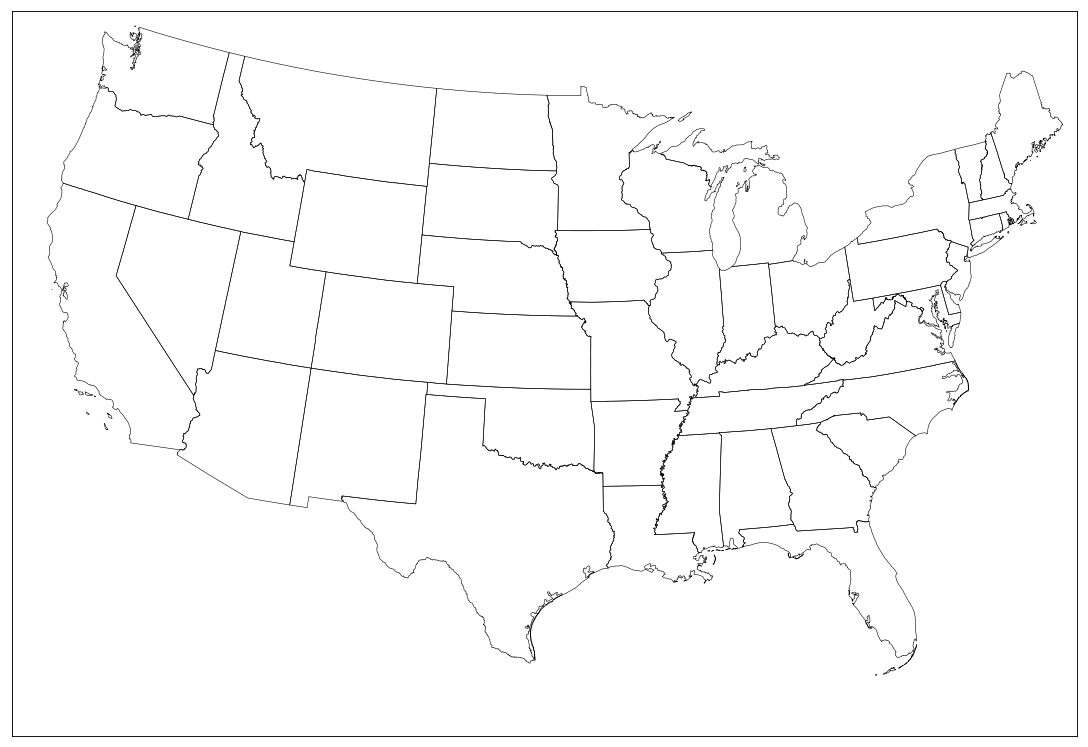

In [190]:
for i in range(0,len(Y1_vecs)):
    tweet_plotter(models[i],Y1_vecs[i])

In [191]:
Y1.loc[:,"cluster"]

0            45
1          4747
2          1464
3          9441
4          7835
5          6158
6          7443
7          3730
8          8965
9          1493
10         9799
11         8884
12         1800
13          650
14          994
15         1869
16         1799
17         7083
18          708
19         3779
20         6077
21         6853
22         7971
23         3621
24         1558
25          837
26         1288
27         5550
28         1464
29         2996
           ... 
2842404    3231
2842405    4829
2842406    1424
2842407    3787
2842408    2722
2842409    4407
2842410    8514
2842411    7913
2842412    1296
2842413    4657
2842414    3150
2842415    8543
2842416       1
2842417    1296
2842418    6431
2842419      45
2842420    5249
2842421     510
2842422     175
2842423    9630
2842424    2926
2842425    6531
2842426    6815
2842427    5918
2842428    5042
2842429     267
2842430    9446
2842431    6714
2842432    8631
2842433     846
Name: cluster, Length: 2

In [43]:
Y1_vecs[1]

state  cluster
0                  Maryland      175
1               Connecticut        0
2                   Arizona        0
3                   Florida        0
4                     Maine        0
5                  Michigan      137
6                     Texas      178
7                  Nebraska      136
8              South Dakota        1
9                   Georgia        0
10                 Delaware       19
11     District of Columbia        0
12                  Vermont      137
13     District of Columbia        0
14                    Idaho      137
15                  Georgia      144
16            New Hampshire        0
17                Louisiana        0
18                   Kansas       19
19                    Maine      136
20                  Florida        1
21                  Arizona      105
22                   Kansas      178
23           South Carolina      137
24            New Hampshire       71
25              Connecticut        0
26           North Carolina        0
27                     Iowa        0
28             South Dakota      136
29            West Virginia      137
...                     ...      ...
39971              Colorado        0
39972            New Mexico       19
39973          Pennsylvania      136
39974             Tennessee      137
39975            California        0
39976                Nevada        0
39977         New Hampshire        0
39978         New Hampshire      178
39979               Florida        0
39980              New York       19
39981              Oklahoma        0
39982              Missouri        0
39983              Michigan        0
39984             Tennessee      178
39985          Pennsylvania      165
39986             Tennessee      116
39987             Tennessee        0
39988          South Dakota      168
39989              Virginia       19
39990               Georgia      170
39991              Delaware       19
39992               Wyoming        1
39993               Montana        0
39994         New Hampshire        0
39995                  Utah       39
39996            New Jersey       32
39997               Indiana      178
39998  District of Columbia        1
39999          Rhode Island        0
40000           Connecticut      178

[40001 rows x 2 columns]

/home/servan/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/servan/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


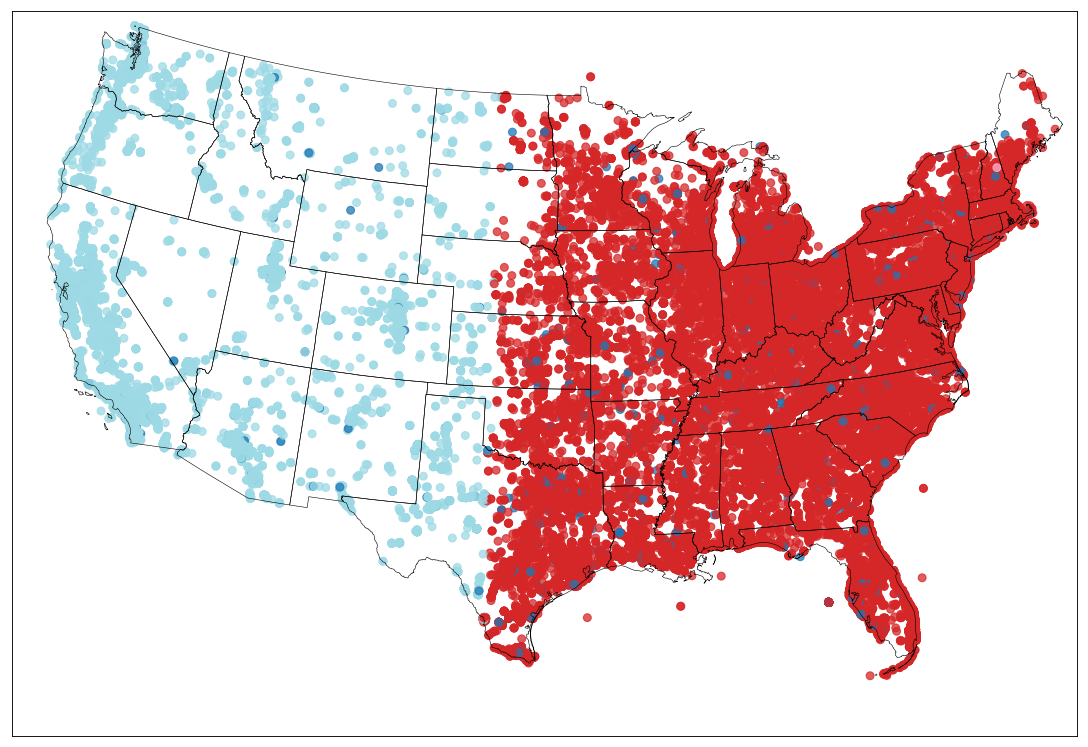

In [352]:
tweet_plotter(models[2],Y1_vecs[2])

In [163]:
def categ_calculator_new(Y1,states_ad,neigh=False):
    categs = []
    indices = list(pd.DataFrame(states_ad)[0])
    nr_states = len(pd.unique(Y1[0]))
    cat_sum = [sum(Y1[1]==i) for i in range(0,len(pd.unique(Y1[1])))]
    print(cat_sum)
    state_sum = [sum(Y1[0]==i) for i in range(0,nr_states)]
    for i in indices:
        #state = i
        #neighbours = states_ad[i]
        state = Y1[Y1[0]==i]
        categ_state = [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_state_rel = [categ_state[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
        """
        categ_sums = np.zeros(len(pd.unique(Y1[1])))
        for k in neighbours:
            state = Y1[Y1[0]==k]
            categ_sums = categ_sums + [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_rel = [categ_sums[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
        """
        arg_state = np.argmax(categ_state_rel)
        #arg_neigh = np.argmax(categ_rel)
        if False: #arg_neigh!=arg_state:
            print(i)
            print(categ_rel)
            print(categ_state_rel)
            print(categ_state)
            print(neighbours)
        #print(categ_rel)
        #print(np.argmax(categ_rel))
        #if True:
        #    categs.append(np.argmax(categ_state_rel))
        if neigh:
            if np.max(categ_state_rel)==1:
                print("case1")
                categs.append(np.argmax(categ_state_rel))
            elif np.max(categ_rel)==1:
                sec_larg = heapq.nlargest(2, range(0,len(categ_rel)), key=categ_rel.__getitem__)
                categs.append(sec_larg[1])
                print("case2")
            else:
                categs.append(np.argmax(categ_rel))
        else:
            categs.append(np.argmax(categ_state_rel))
        #categs.append(np.argmax(categ_rel))
    print(len(categs))
    return(categs)
    #print(categ_rel)
    #print(np.argmax(categ_rel))
    #print(categ_rel)

In [164]:
def state_plotter_old(Y1):
    nr_states = len(pd.unique(Y1[0]))
    """
    nr_states = len(pd.unique(Y1[0]))
    cat_sum = [sum(Y1[1]==i) for i in range(0,len(pd.unique(Y1[1])))]
    state_sum = [sum(Y1[0]==i) for i in range(0,nr_states)]

    categs = []
    for i in range(0,nr_states):
        state = Y1[Y1[0]==i]
        categ_sums = [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_rel = [categ_sums[k]/cat_sum[k] for k in range(0,len(pd.unique(Y1[1])))]
        #print(categ_rel)
        #print(np.argmax(categ_rel))
        #print(categ_rel)
        categs.append(np.argmax(categ_rel))
    
    print(categs)
    """
    categs = categ_calculator_new(Y1,states_ad)
    uniq_categs = pd.unique(categs)
    cols = plt.cm.tab10(uniq_categs)

    # create the map
    map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # load the shapefile, use the name 'states'
    map.readshapefile('st99_d00', name='states', drawbounds=True)

    # collect the state names from the shapefile attributes so we can
    # look up the shape obect for a state by it's name
    state_names = []
    for shape_dict in map.states_info:
        state_names.append(shape_dict['NAME'])
    print(len(state_names))
    ax = plt.gca() # get current axes instance

    # get states and draw the filled polygon
    for i in range(0,nr_states):
        #seg = map.states[state_names.index(states[i])]
        #seg = map.states[state_names.index("Michigan")]
        indices = [k for k, x in enumerate(state_names) if x == states[i]]
        col = categs[i]
        ind = uniq_categs==col
        col = list(cols[ind])[0]
        for j in range(0,len(indices)):
            seg = map.states[indices[j]]
            poly = Polygon(seg, facecolor=col,edgecolor=col)
            ax.add_patch(poly)

    plt.show()

[6721, 8833, 3514]
49
273


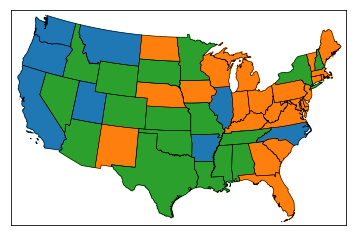

In [165]:
state_plotter_old(Y1_vecs[1])

[12027, 7041]
49
273


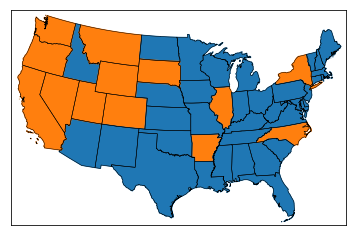

[6721, 8833, 3514]
49
273


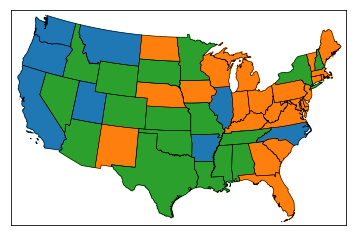

[2819, 6721, 3381, 6147]
49
273


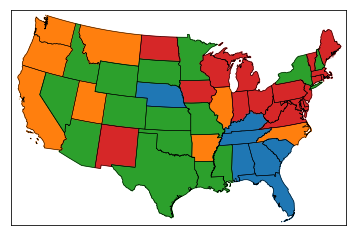

[4363, 5554, 2973, 1167, 5011]
49
273


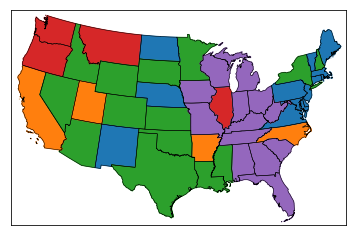

[5554, 3030, 2523, 4029, 2765, 1167]
49
273


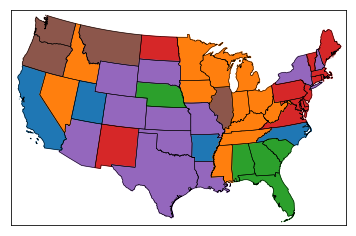

[2614, 5556, 3614, 2583, 1369, 2165, 1167]
49
273


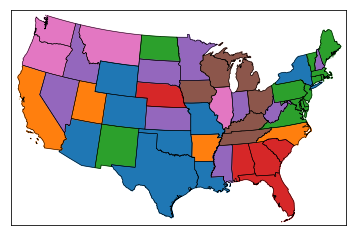

[1077, 5407, 3862, 2506, 1146, 1915, 2667, 488]
49
273


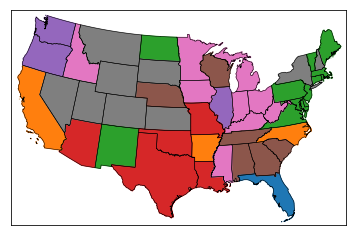

[1894, 4873, 3911, 2489, 1118, 2664, 1076, 390, 653]
49
273


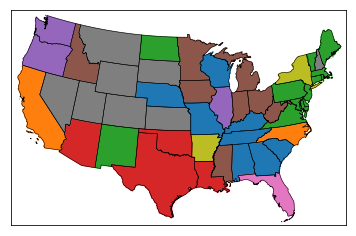

[5377, 3551, 788, 1931, 1139, 1085, 479, 1200, 1915, 1603]
49
273


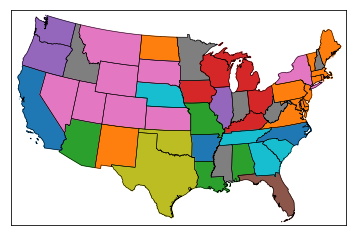

[698, 1413, 2655, 2157, 1151, 1205, 2239, 1086, 1825, 3224, 1415]
49
273


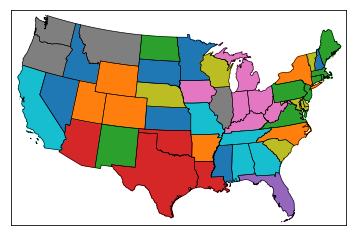

[838, 1327, 1393, 1932, 996, 1117, 1748, 4338, 1115, 2551, 546, 1167]
49
273


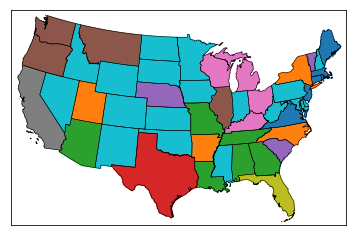

[3742, 1410, 1888, 1910, 1086, 508, 1387, 1080, 907, 1748, 1206, 1395, 801]
49
273


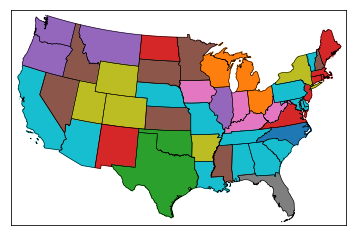

[3715, 1468, 1889, 1072, 1082, 2435, 385, 1243, 1309, 1206, 468, 1495, 719, 582]
49
273


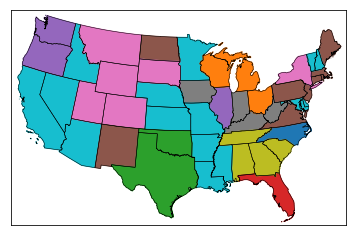

[800, 3739, 859, 1072, 1204, 621, 1754, 1082, 1363, 333, 1952, 726, 1157, 594, 1812]
49
273


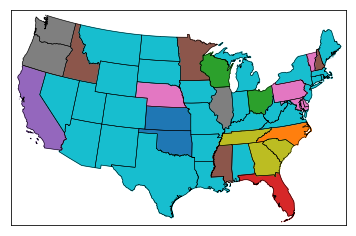

[1205, 1054, 1704, 320, 1725, 1086, 1099, 1119, 1195, 265, 1832, 3191, 1439, 803, 697, 334]
49
273


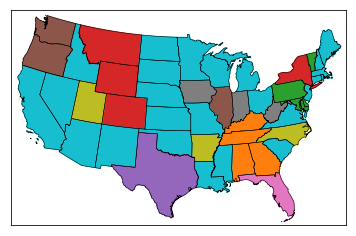

[1098, 822, 1308, 1079, 1444, 693, 1165, 1239, 1901, 1072, 535, 201, 323, 1420, 1095, 3208, 465]
49
273


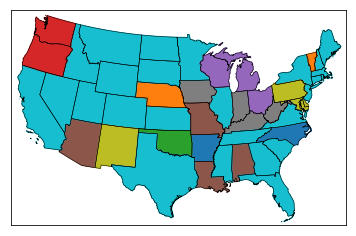

[1100, 3192, 1441, 767, 1072, 1083, 1877, 1309, 656, 1204, 1423, 273, 567, 1150, 182, 401, 718, 653]
49
273


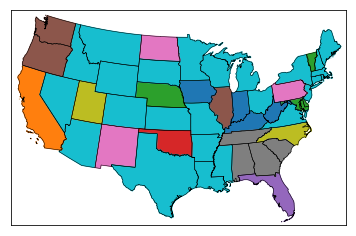

[1079, 1071, 1896, 3737, 405, 674, 652, 331, 1206, 743, 735, 548, 1619, 594, 461, 530, 788, 837, 1162]
49
273


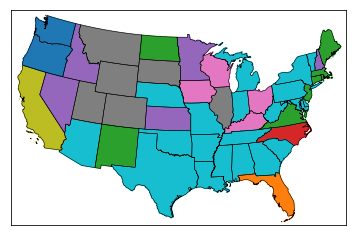

In [166]:
for i in range(0,len(Y1_vecs)):
    state_plotter_old(pd.DataFrame(Y1_vecs[i]))

In [119]:
#transform state strings into integer labels
le = preprocessing.LabelEncoder()
le.fit(Y)
list(le.classes_)
Y = pd.Series(le.transform(Y))

In [120]:
states_ad = [list(le.transform(i)) for i in states_ad]

ValueError: y contains new labels: ['Rhode Island']

In [16]:
states_ad = sorted(states_ad)

In [17]:
#split data into smaller subsets
n_splits = 100
splits = list(range(1,n_splits))
splits = [i/n_splits for i in splits]
Y_splits = np.split(Y, [int(i*len(Y)) for i in splits])
X_splits = np.split(X,[int(i*len(Y)) for i in splits])

In [18]:
for i in X_splits:
    print(len(i))

6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6720
6721
6720
6720
6721


# Old stuff

In [332]:
#old code to test whether clustering works with coordinates
#joint = pd.concat([x_start,y_start],axis=1)
_lambda = 0.1
X[['lat','lon']] = pd.DataFrame(Y['coord'].values.tolist(), columns=['x','y'])
X['lat'] = X['lat'].apply(lambda x: x*_lambda)
X['lon'] = X['lon'].apply(lambda x: x*_lambda)
print (X)

               0         1         2         3         4         5         6  \
0       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      -0.057968  0.239050 -0.157540 -0.102330 -0.052477  0.398420  0.030478   
2      -0.069931  0.052453  0.071276  0.110880 -0.026561  0.212230 -0.244550   
3      -0.001827  0.011836 -0.087708  0.146680 -0.229120  0.098161  0.154060   
4      -0.101660 -0.082736  0.072445  0.007983 -0.006668  0.233310  0.147490   
5      -0.117000  0.078228 -0.074029 -0.037452 -0.063964  0.155570 -0.022898   
6      -0.111680  0.212090  0.097589 -0.124490  0.027603  0.030855  0.037793   
7      -0.225290 -0.170080  0.056797  0.112650 -0.038840 -0.043256  0.035797   
8       0.069042  0.009077  0.117250  0.348340 -0.043387  0.146760 -0.128050   
9      -0.127140 -0.130130 -0.180420 -0.140870  0.042621 -0.025003 -0.001276   
10      0.273310  0.143440 -0.047267 -0.049857  0.109150  0.172220  0.000752   
11     -0.127440 -0.055781  0.053006  0.

In [38]:
#get state adjacency
with open("stateadjacency.txt") as f:
    states_ad = f.read().splitlines() 
states_ad = [i.split(",") for i in states_ad]

for k in range(0,len(states_ad)):
    states_ad[k] = [states_dict.get(item) for item in states_ad[k]]

#revome states that are not in our subset
states_ad = [i for i in states_ad if i!=[None]]
states_ad

[['Alabama', 'Mississippi', 'Tennessee', 'Georgia', 'Florida'],
 ['Arkansas',
  'Missouri',
  'Tennessee',
  'Mississippi',
  'Louisiana',
  'Texas',
  'Oklahoma'],
 ['Arizona', 'California', 'Nevada', 'Utah', 'Colorado', 'New Mexico'],
 ['California', 'Oregon', 'Nevada', 'Arizona'],
 ['Colorado',
  'Wyoming',
  'Nebraska',
  'Kansas',
  'Oklahoma',
  'New Mexico',
  'Arizona',
  'Utah'],
 ['Connecticut', 'New York', 'Massachusetts', 'Rhode Island'],
 ['District of Columbia', 'Maryland', 'Virginia'],
 ['Delaware', 'Maryland', 'Pennsylvania', 'New Jersey'],
 ['Florida', 'Alabama', 'Georgia'],
 ['Georgia',
  'Florida',
  'Alabama',
  'Tennessee',
  'North Carolina',
  'South Carolina'],
 ['Iowa',
  'Minnesota',
  'Wisconsin',
  'Illinois',
  'Missouri',
  'Nebraska',
  'South Dakota'],
 ['Idaho', 'Montana', 'Wyoming', 'Utah', 'Nevada', 'Oregon', 'Washington'],
 ['Illinois', 'Indiana', 'Kentucky', 'Missouri', 'Iowa', 'Wisconsin'],
 ['Indiana', 'Michigan', 'Ohio', 'Kentucky', 'Illinois'],


In [19]:
#merged = list(itertools.chain.from_iterable(list2d))
def ad_matrix(Y,states_ad):
    rows = cols = len(Y)
    ad_mat = sps.coo_matrix((rows, cols))
    indices = list(pd.DataFrame(states_ad)[0])
    for j in indices: 
        r = np.where(Y.isin([j]))[0]
        tw_per_state = len(r)
        c = np.where(Y.isin(states_ad[j]))[0]
        #c = np.where(Y.isin([j]))[0]
        neigh_per_tweet = len(c)
        r = np.repeat([r],neigh_per_tweet,axis=1)
        r = list(itertools.chain.from_iterable(r))
        #print(r)
        c = np.repeat([c],tw_per_state,axis=0)
        c = list(itertools.chain.from_iterable(c))
        #print(c)
        d = np.ones(len(c))
        ad_mat = ad_mat + sps.coo_matrix((d, (r, c)), shape=(rows, cols))
    #print(ad_mat)
    return(ad_mat)

def categ_calculator(Y1,states_ad,neigh=False):
    categs = []
    indices = list(pd.DataFrame(states_ad)[0])
    nr_states = len(pd.unique(Y1[0]))
    cat_sum = [sum(Y1[1]==i) for i in range(0,len(pd.unique(Y1[1])))]
    print(cat_sum)
    state_sum = [sum(Y1[0]==i) for i in range(0,nr_states)]
    for i in indices:
        #state = i
        neighbours = states_ad[i]
        state = Y1[Y1[0]==i]
        categ_state = [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_state_rel = [categ_state[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
        categ_sums = np.zeros(len(pd.unique(Y1[1])))
        for k in neighbours:
            state = Y1[Y1[0]==k]
            categ_sums = categ_sums + [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
        categ_rel = [categ_sums[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
       
        arg_state = np.argmax(categ_state_rel)
        arg_neigh = np.argmax(categ_rel)
        if False: #arg_neigh!=arg_state:
            print(i)
            print(categ_rel)
            print(categ_state_rel)
            print(categ_state)
            print(neighbours)
        #print(categ_rel)
        #print(np.argmax(categ_rel))
        #if True:
        #    categs.append(np.argmax(categ_state_rel))
        if neigh:
            if np.max(categ_state_rel)==1:
                print("case1")
                categs.append(np.argmax(categ_state_rel))
            elif np.max(categ_rel)==1:
                sec_larg = heapq.nlargest(2, range(0,len(categ_rel)), key=categ_rel.__getitem__)
                categs.append(sec_larg[1])
                print("case2")
            else:
                categs.append(np.argmax(categ_rel))
        else:
            categs.append(np.argmax(categ_state_rel))
        #categs.append(np.argmax(categ_rel))
    print(len(categs))
    return(categs)
    #print(categ_rel)
    #print(np.argmax(categ_rel))
    #print(categ_rel)

def neigh_calc(categs,neigh_mat):
    row = len(neigh_mat)
    print(row)
    #creates a connectivity matrix with ones if states belong to the same cluster and 0 if they dont'
    for j in range(0,row):
        cat_j = categs[j]
        neighs = [(i==cat_j)*1 for i in categs]
        neigh_mat[j,:] = neigh_mat[j,:]+neighs
    return(neigh_mat)


#see http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering for agglomerative clustering
def neighbour_finder(X,Y,size=49):
    row = col = size
    neigh_mat_state = np.zeros([row,col])
    neigh_mat_neigh = np.zeros([row,col])
    print("number of unique states",len(np.unique(Y)))
    #calculate adjacency matrix
    rows = cols = len(Y)
    print("Size of ad_mat:",rows)
    ad_mat = sps.coo_matrix((rows, cols))
    indices = list(pd.DataFrame(states_ad)[0])

    ad_mat = ad_matrix(Y,states_ad)
    print("adjacency matrix calculated")
        
    #reduce dimensions via pca
    pca = PCA(n_components=50, 
                     copy=True, whiten=False, svd_solver="auto", tol=0.0, 
                     iterated_power="auto", random_state=None)
    X_pca = pca.fit_transform(X)
        
    print("PCA done")
    #create cluster model
    #agg_cluster = AgglomerativeClustering(n_clusters=5, affinity="cosine", memory=None, connectivity=ad_mat, 
                                        #compute_full_tree="True", linkage="average")
    agg_cluster = AgglomerativeClustering(n_clusters=5, affinity="euclidean", memory=None, connectivity=ad_mat, 
                                        compute_full_tree="False", linkage="ward")
    print("agg_cluster model built")
    labels = pd.Series(agg_cluster.fit_predict(X_pca))
    print("clustering done and labels assigned")
    Y.reset_index(drop=True, inplace=True)
    labels.reset_index(drop=True, inplace=True)

    Y1 = pd.concat([Y,labels],axis=1,ignore_index=True)
    print(pd.unique(Y1[1]))
        
    #calculate majority label for each state, based on values within state only
    #"categs_state" and values in state_neighbourhood conly "categs_neigh"
    categs_state = categ_calculator(Y1,states_ad,neigh=False)
    categs_neigh = categ_calculator(Y1,states_ad,neigh=True)
    print("neighbours calculated")
        
    #calculate neighbour
    neigh_mat_neigh = neigh_calc(categs_neigh,neigh_mat_neigh)
    neigh_mat_state = neigh_calc(categs_state,neigh_mat_state)
    #np.save("neigh_mat_state_200k.npy",neigh_mat_state)
    #np.save("neigh_mat_neigh_200k.npy",neigh_mat_neigh)
    #print(str(i),"th split processed\n")
    
    return([neigh_mat_neigh,neigh_mat_state])

In [20]:
size = 49
zipped_splits = list(zip(X_splits,Y_splits,np.repeat(size,len(X_splits))))

pool = mp.pool.ThreadPool(int(mp.cpu_count()/2))

nei_mat = pool.starmap(neighbour_finder, zipped_splits,chunksize =1)

pool.close()

#sum all resultsq
nei_mat = np.sum(nei_mat,axis=0)
neigh_mat_neigh = nei_mat[0]
neigh_mat_state = nei_mat[1]

np.save("neigh_mat_neigh_600k.npy",neigh_mat_neigh)
np.save("neigh_mat_state_600k.npy",neigh_mat_state)

number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6721
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6721
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6721
number of unique states 49
Size of ad_mat: 6721
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6721
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6721
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_mat: 6720
number of unique states 49
Size of ad_ma

case2
case2
case2case2

case2
PCA done
agg_cluster model built
case2
49
neighbours calculated
49
49
number of unique states 49
Size of ad_mat: 6720
case2
case2
case2
case2
adjacency matrix calculated
49
neighbours calculated
49
case2
49
number of unique states 49
Size of ad_mat: 6721
case1
adjacency matrix calculated
case2
case2
case2
PCA doneadjacency matrix calculated

case2
agg_cluster model built
case2
case2
case2
adjacency matrix calculated
case2
case2
case1
case2
PCA done
agg_cluster model built
case1
PCA done
agg_cluster model built
case2
case2case1
case2

case2
PCA done
agg_cluster model built
case2
49
neighbours calculated
49
49
case2case2

number of unique states 49
Size of ad_mat: 6720
case2
case2
case2
case2
case2case2

49
neighbours calculated
49
case2
49
number of unique states 49
Size of ad_mat: 6720
49
neighbours calculated
49
49case2

49
neighbours calculated
49
number of unique states 49
Size of ad_mat: 6720
49
number of unique statescase2 
49
Size of ad_mat: 6721
cas

49
neighbours calculated
49
49
number of unique states 49
Size of ad_mat: 6720
49
neighbours calculated
49
49
adjacency matrix calculated
number of unique states 49
Size of ad_mat: 6720
adjacency matrix calculated
PCA done
agg_cluster model built
PCA done
agg_cluster model built
adjacency matrix calculated
PCA done
agg_cluster model built
adjacency matrix calculated
PCA done
agg_cluster model built
adjacency matrix calculated
adjacency matrix calculated
PCA done
agg_cluster model built
PCA done
agg_cluster model built
adjacency matrix calculated
PCA done
agg_cluster model built
clustering done and labels assigned
[1 0 2 4 3]
[166, 6548, 2, 1, 3]
clustering done and labels assigned
[1 2 3 0 4]
[2, 6589, 126, 1, 3]
49
[166, 6548, 2, 1, 3]
case2
case2
case2
49
[2, 6589, 126, 1, 3]
case2
case2
case2
case2
case2
case2
case2
case2
case2
case1
case2
case2
case2
case2
case2
case2
49
neighbours calculated
49
49
number of unique states 49
Size of ad_mat: 6720
case2
case1
case2
case2
49
neighbour

case2
case2
case2
49
neighbours calculated
49
49
number of unique states 49
Size of ad_mat: 6720
clustering done and labels assigned
[0 1 3 4 2]
[6618, 98, 2, 1, 1]
49
[186, 100, 1, 6432, 1]
case2
case2
case1
case2
adjacency matrix calculated
PCA done
agg_cluster model built
case2
case1
case2
case2
clustering done and labels assigned
[0 2 1 3 4]
[6714, 3, 1, 1, 1]
clustering done and labels assigned
[4 1 0 2 3]
[20, 240, 2, 1, 6458]
case2
49
[6618, 98, 2, 1, 1]
case2
case2
case1
case1
case1
49
neighbours calculated
49
49
clustering done and labels assigned
[4 0 2 1 3]
number of unique states 49
Size of ad_mat: 6720
[133, 4, 37, 2, 6545]
case2
case2
case2
case2
case2
49
adjacency matrix calculated
[6714, 3, 1, 1, 1]
49
neighbours calculated
49
49
number of unique states 49
Size of ad_mat: 6721
PCA done
agg_cluster model built
49
clustering done and labels assigned
[0 1 4 2 3]
[20, 240, 2, 1, 6458]
[6610, 103, 1, 1, 5]
case2
case2
case2
case2
clustering done and labels assigned
[0 2 1 3 

In [32]:
neigh_mat_neigh = nei_mat[0]/n_splits
neigh_mat_state = nei_mat[1]/n_splits

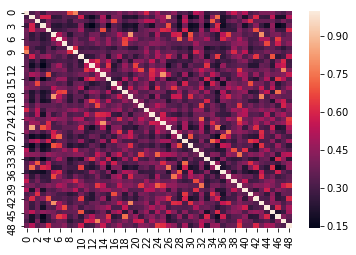

In [33]:
sns.heatmap(np.array(neigh_mat_neigh))

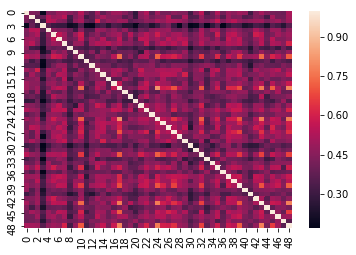

In [34]:
sns.heatmap(np.array(neigh_mat_state))

In [35]:
def find_neigh(ngh_mat,thresh=0.1):
    nghs = []
    for i in range(0,len(ngh_mat)):
        ngh = np.where([j>thresh for j in ngh_mat[i]])
        nghs.append(ngh)
    return(nghs)
        

In [36]:
def prune_edges(ngh_mat,thresh=0.1):
    new_mat = deepcopy(ngh_mat)
    sub_thresh_idx = [j<thresh for j in ngh_mat]
    new_mat[sub_thresh_idx] = 0
    return(new_mat)

In [37]:
test_mat = prune_edges(neigh_mat_neigh,thresh=0.5)
G = nx.from_numpy_matrix(test_mat)

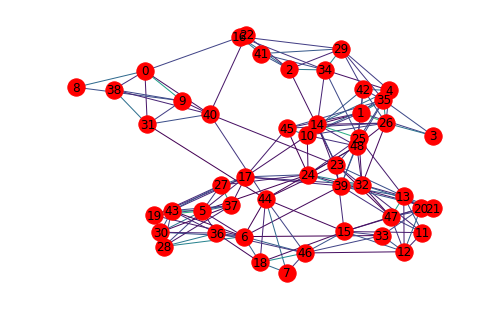

In [38]:
edgewidth = [d['weight']*2 for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G,k=0.4,iterations=40)
nx.draw(G,edge_color=edgewidth,with_labels=True,linewidth=edgewidth,pos=pos)

In [46]:
thresh09 = prune_edges(neigh_mat_neigh,thresh=0.9)
thresh07 = prune_edges(neigh_mat_neigh,thresh=0.7)
thresh06 = prune_edges(neigh_mat_neigh,thresh=0.6)
thresh05 = prune_edges(neigh_mat_neigh,thresh=0.5)
thresh03 = prune_edges(neigh_mat_neigh,thresh=0.3)
thresh01 = prune_edges(neigh_mat_neigh,thresh=0.1)

In [40]:
def state_plotter_new(mat):
    G = nx.from_numpy_matrix(mat)
    # create the map
    plt.figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
    nr_states = len(pd.unique(Y))
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    # load the shapefile, use the name 'states'
    m.readshapefile('st99_d00', name='states', drawbounds=True)
    state_names = []
    for shape_dict in m.states_info:
        state_names.append(shape_dict['NAME'])
    print(len(state_names))
    ax = plt.gca() # get current axes instance
    pos = {}
    for i in range(0,nr_states):
        #seg = map.states[state_names.index(states[i])]
        #seg = map.states[state_names.index("Michigan")]
        indices = [k for k, x in enumerate(state_names) if x == states[i]]

    
        seg = [np.sum(m.states[k],0) for k in indices]
        nr_seg = [len(m.states[k]) for k in indices]
        seg_avg = [seg[k]/nr_seg[k] for k in range(0,len(seg))]
        seg_avg = np.mean(seg_avg,0)
        pos[i] = (seg_avg[0],seg_avg[1])

    nx.draw(G,with_labels=True,linewidth=edgewidth,pos=pos,node_size=100)

273


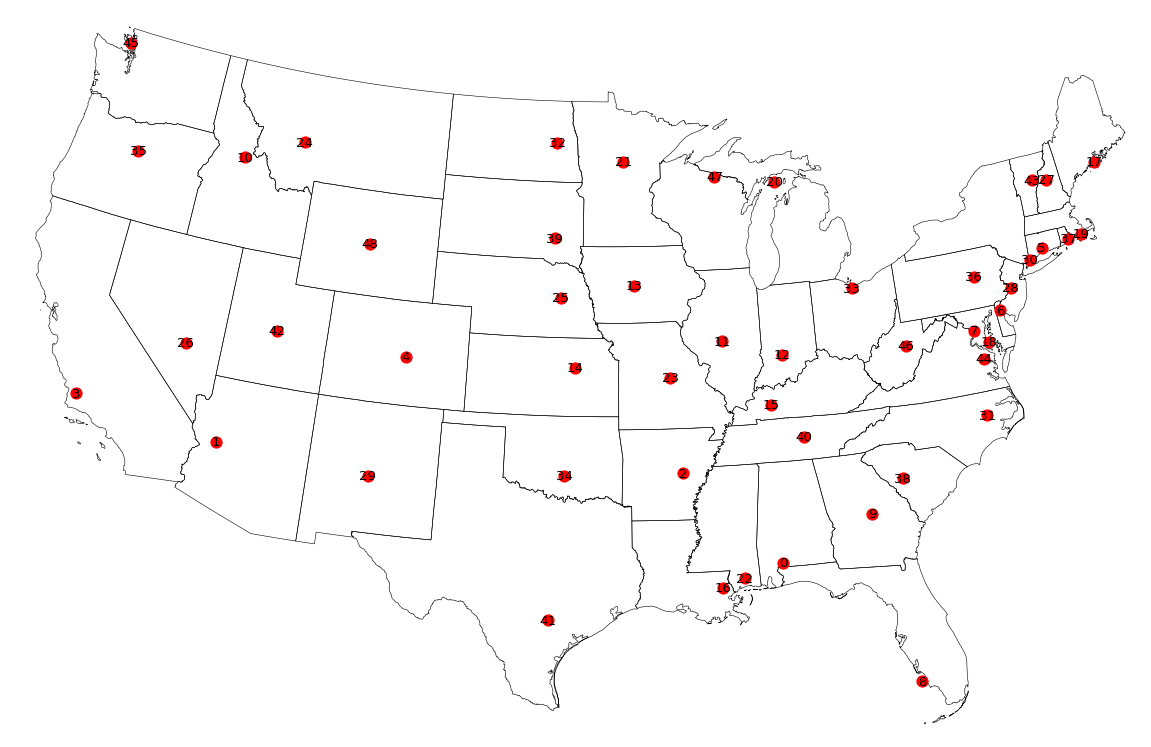

In [41]:
state_plotter_new(thresh09)

273


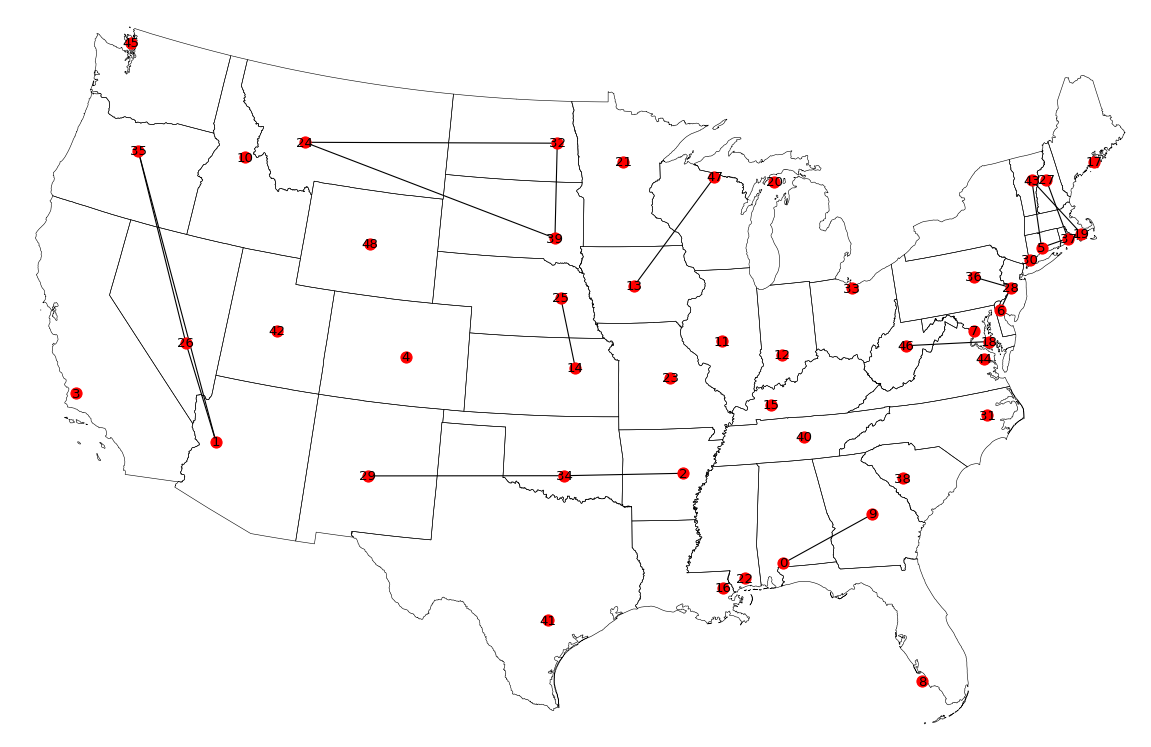

In [42]:
state_plotter_new(thresh07)

273


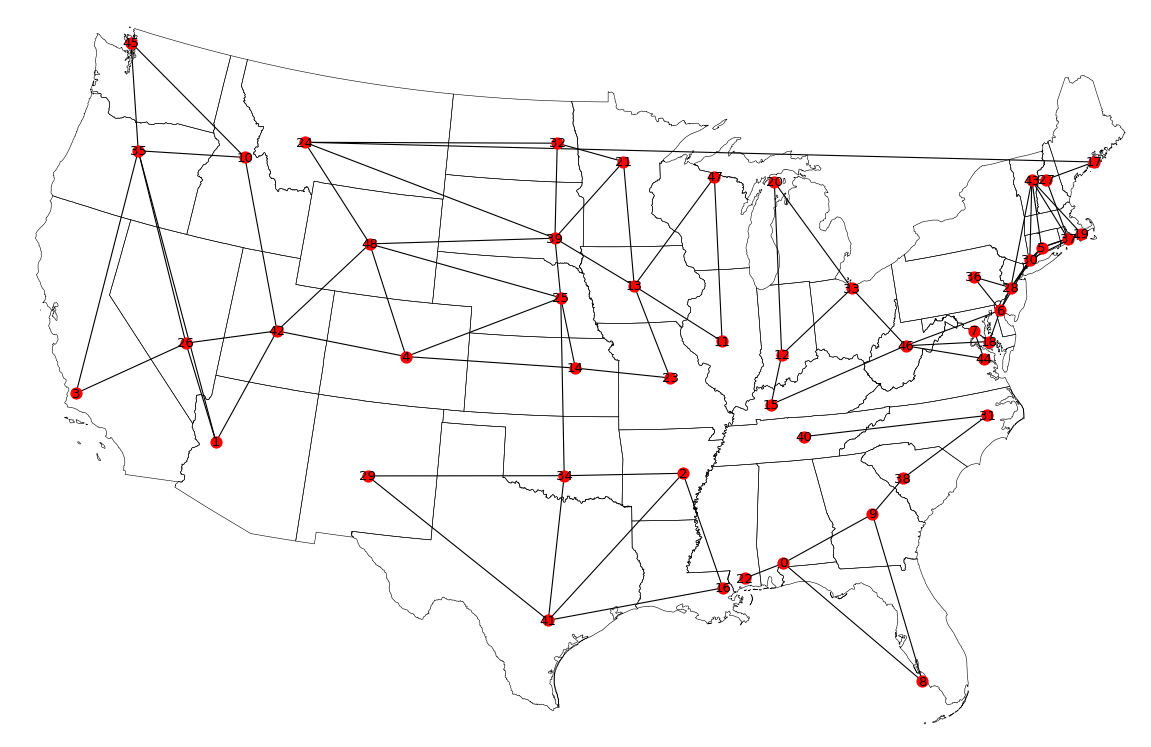

In [47]:
state_plotter_new(thresh06)

273


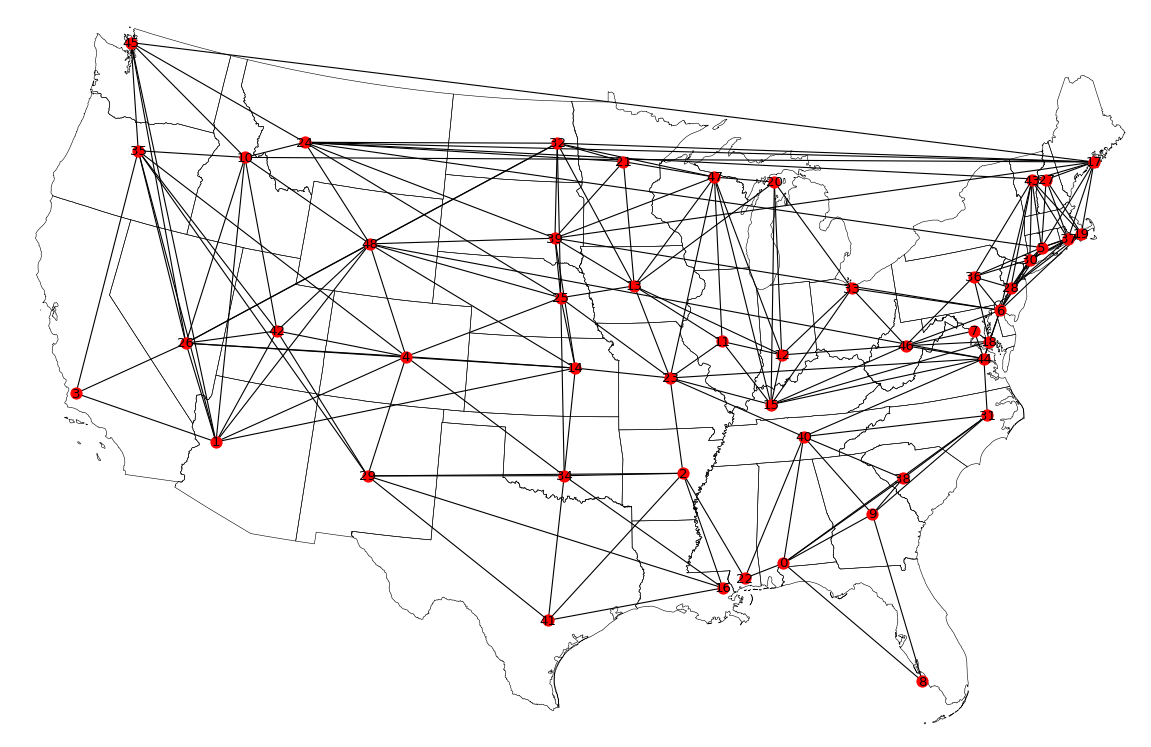

In [43]:
state_plotter_new(thresh05)

273


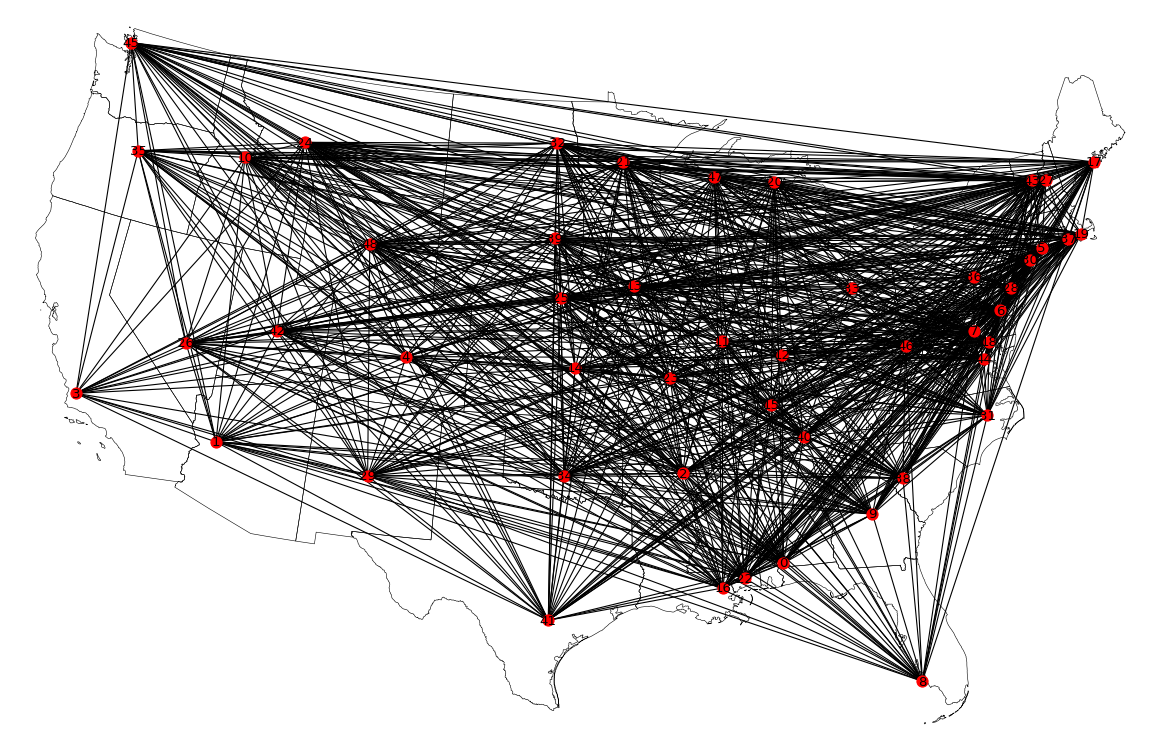

In [44]:
state_plotter_new(thresh03)

273


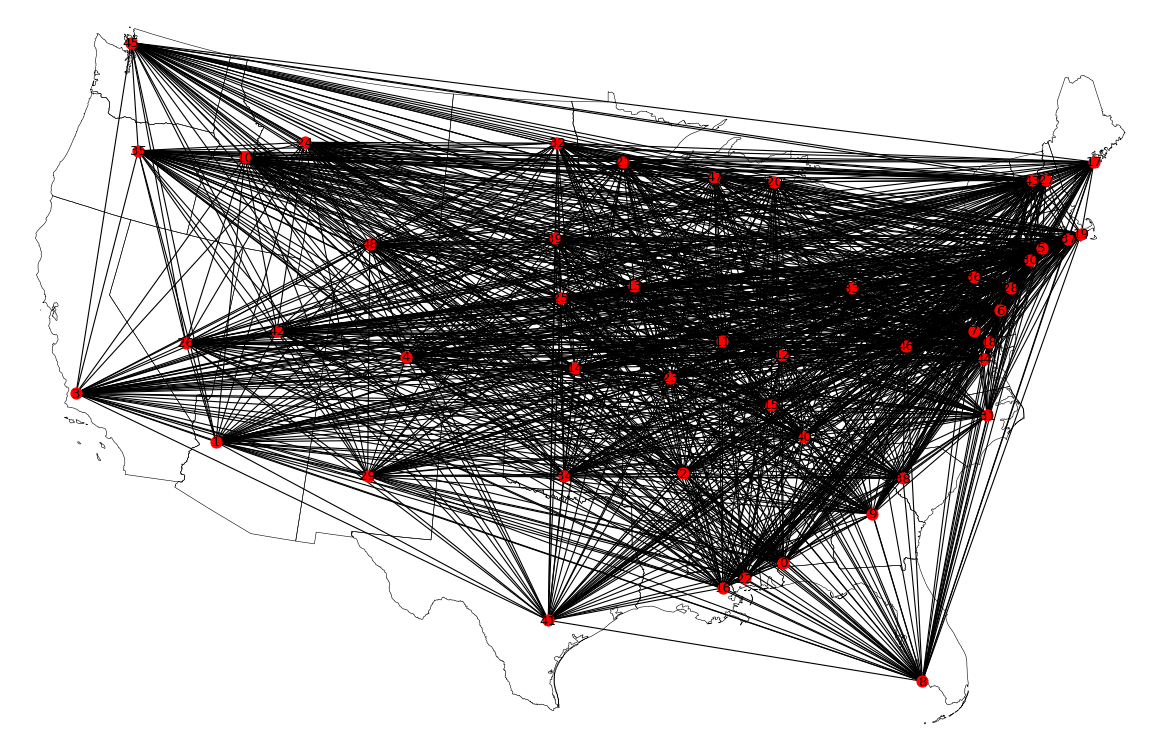

In [45]:
state_plotter_new(thresh01)

# Ignore below

In [64]:
rows = cols = len(Y)
ad_mat = sps.coo_matrix((rows, cols))
indices = list(pd.DataFrame(states_ad)[0])
print(indices)

def comp_ad_mat(j,ad_mat):
    #Y = avg_Y
    r = np.where(Y.isin([j]))[0]
    tw_per_state = len(r)
    c = np.where(Y.isin(states_ad[j]))[0]
    #c = np.where(Y.isin([j]))[0]
    neigh_per_tweet = len(c)
    r = np.repeat([r],neigh_per_tweet,axis=1)
    r = list(itertools.chain.from_iterable(r))
    #print(r)
    c = np.repeat([c],tw_per_state,axis=0)
    c = list(itertools.chain.from_iterable(c))
    #print(c)
    d = np.ones(len(c))
    ad_mat = ad_mat + sps.coo_matrix((d, (r, c)), shape=(rows, cols))
    return(ad_mat)
        
if __name__ == '__main__':
    results = Parallel(n_jobs=mp.cpu_count()-2)(delayed(comp_ad_mat)(j,ad_mat) for j in indices)

ad_mat = sps.coo_matrix((rows, cols))
for i in range(0,len(results)):
    print(i)
    ad_mat = ad_mat + results[i]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [375]:
#regions = Y
regions = pd.Series(np.zeros(len(Y)))
for i in range(len(lingo_regions.keys())):
    reg_ind = Y.isin(list(lingo_regions.values())[i])
    regions[reg_ind] = [list(lingo_regions.keys())[i]]*sum(reg_ind)
    #regions[reg_ind] = [i]*sum(reg_ind)

In [65]:
ad_mat

<9446x9446 sparse matrix of type '<class 'numpy.float64'>'
	with 14318992 stored elements in Compressed Sparse Row format>

In [48]:
ad_mat

<47340x47340 sparse matrix of type '<class 'numpy.float64'>'
	with 104613790 stored elements in Compressed Sparse Row format>

### read sent-vector

In [25]:
X = tfidf_bigrams[0:10001,:]

In [66]:
print(np.shape(Y))
print(np.shape(X))

(9446,)
(9446, 700)


In [352]:
#dimensionality reduction
pca = PCA(n_components=10, 
                         copy=True, whiten=False, svd_solver="auto", tol=0.0, 
                         iterated_power="auto", random_state=None)
X_pca = pca.fit_transform(X)

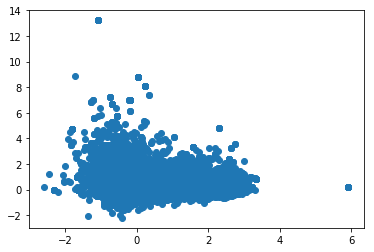

In [361]:
plt.scatter(X_pca[:,1],X_pca[:,3])

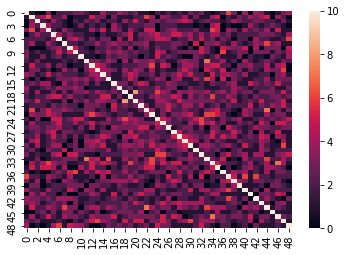

In [348]:
import seaborn as sns
sns.heatmap(np.array(nei_mat[1]))

In [81]:
agg_cluster = AgglomerativeClustering(n_clusters=5, affinity="euclidean", memory=".", connectivity=ad_mat, 
                                        compute_full_tree="auto", linkage="ward")

In [82]:
labels = pd.Series(agg_cluster.fit_predict(X_pca))

In [83]:
labels

0       0
1       0
2       2
3       0
4       2
5       2
6       4
7       2
8       2
9       2
10      3
11      3
12      0
13      0
14      3
15      3
16      2
17      2
18      2
19      2
20      1
21      2
22      2
23      0
24      2
25      0
26      1
27      2
28      2
29      2
       ..
9416    2
9417    0
9418    0
9419    2
9420    2
9421    0
9422    0
9423    4
9424    2
9425    2
9426    0
9427    2
9428    0
9429    2
9430    3
9431    2
9432    2
9433    2
9434    2
9435    2
9436    2
9437    0
9438    2
9439    2
9440    2
9441    2
9442    2
9443    2
9444    2
9445    0
Length: 9446, dtype: int64

In [92]:
Y1 = pd.concat([Y,labels],1)

In [ ]:
Y1.to_pickle("Y1.pkl")

In [ ]:
n_clusts = range(2,15)
models = []
labels = []
Y1_vecs = []
for i in n_clusts:
    cluster_model = AgglomerativeClustering(n_clusters=i, affinity="cosine", memory=".", connectivity=ad_mat, 
                                        compute_full_tree="auto", linkage="average")
    #cluster_model = DBSCAN(eps=0.5, min_samples=5, metric="cosine", 
    #                       metric_params=None, algorithm="brute", leaf_size=30, p=None, n_jobs=8)
    models.append(cluster_model)
    cluster_model.fit(X)
    label = pd.Series(cluster_model.predict(X))
    labels.append(label)
    Y1 = pd.concat([Y,label],1)
    Y1_vecs.append(Y1)

In [288]:
np.argmax(None)

0

In [125]:
categs_state = categ_calculator(Y1,states_ad,neigh=False)
categs_neigh = categ_calculator(Y1,states_ad,neigh=True)

[2640, 410, 5243, 892, 261]
[2640, 410, 5243, 892, 261]


In [123]:
row = col = len(np.unique(Y))
neighbours_matrix = np.zeros([row,col])
for j in range(0,row):
    cat_j = categs[j]
    neighs = [(i==cat_j)*1 for i in categs]
    neighbours_matrix[j,:] = neighbours_matrix[j,:]+neighs

In [119]:
np.save("neigh_mat_state.npy",neighbours_matrix)

In [532]:
state = Y1[Y1[0]==24]        
categ_state = [sum(state[1]==j) for j in range(0,len(pd.unique(Y1[1])))]
categ_state_rel = [categ_state[l]/cat_sum[l] for l in range(0,len(pd.unique(Y1[1])))]
print(categ_state)
print(categ_state_rel)

[6, 0, 0, 0, 0]
[0.0020646937370956643, 0.0, 0.0, 0.0, 0.0]


In [531]:
indices = list(pd.DataFrame(states_ad)[0])
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [538]:
ind = le.transform(["Colorado"])
print(ind)
#Y1[Y==ind[0]]


[4]


[45, 1, 1, 1, 1]
4
[0.15555555555555556, 1.0, 0.0, 0.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[4, 48, 25, 14, 34, 29, 1, 42]
case2
10
[0.1111111111111111, 1.0, 0.0, 1.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[10, 24, 48, 42, 26, 35, 45]
case2
13
[0.13333333333333333, 0.0, 1.0, 0.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[13, 21, 47, 11, 23, 25, 39]
case2
21
[0.066666666666666666, 0.0, 1.0, 0.0, 1.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[21, 47, 13, 39, 32]
case2
24
[0.022222222222222223, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 1.0, 0.0]
[0, 0, 0, 1, 0]
[24, 32, 39, 48, 10]
24
[0.022222222222222223, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 1.0, 0.0]
[0, 0, 0, 1, 0]
[24, 32, 39, 48, 10]
case1
25
[0.1111111111111111, 1.0, 1.0, 0.0, 0.0]
[0.022222222222222223, 0.0, 0.0, 0.0, 0.0]
[1, 0, 0, 0, 0]
[25, 39, 13, 23, 14, 4, 48]
case2
32
[0.022222222222222223, 0.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 1.0]
[

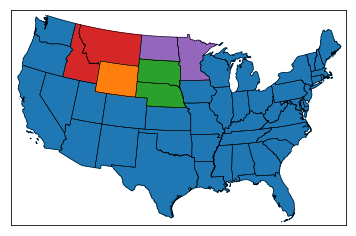

In [39]:
state_plotter(Y1)

In [13]:
from sklearn.neighbors.ball_tree import BallTree
print(BallTree.valid_metrics)

['braycurtis', 'haversine', 'dice', 'l2', 'jaccard', 'canberra', 'hamming', 'euclidean', 'manhattan', 'sokalmichener', 'infinity', 'minkowski', 'kulsinski', 'mahalanobis', 'chebyshev', 'seuclidean', 'matching', 'l1', 'cityblock', 'russellrao', 'pyfunc', 'rogerstanimoto', 'sokalsneath', 'p', 'wminkowski']


0       0
1       0
2       2
3       0
4       2
5       2
6       4
7       2
8       2
9       2
10      3
11      3
12      0
13      0
14      3
15      3
16      2
17      2
18      2
19      2
20      1
21      2
22      2
23      0
24      2
25      0
26      1
27      2
28      2
29      2
       ..
9416    2
9417    0
9418    0
9419    2
9420    2
9421    0
9422    0
9423    4
9424    2
9425    2
9426    0
9427    2
9428    0
9429    2
9430    3
9431    2
9432    2
9433    2
9434    2
9435    2
9436    2
9437    0
9438    2
9439    2
9440    2
9441    2
9442    2
9443    2
9444    2
9445    0
Length: 9446, dtype: int64

In [205]:
list(cols[1])

[0.8901960784313725, 0.46666666666666667, 0.76078431372549016, 1.0]

273


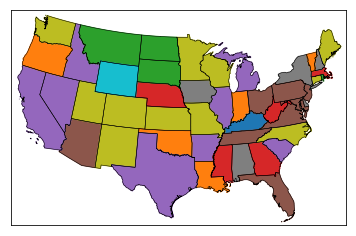

In [293]:
my_tab = pd.crosstab(index=Y,  # Make a crosstab
                              columns="count")
my_tab

In [270]:
len(map.states[2])

15

In [256]:
statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    print(statename)
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        pop = popdensity[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
    statenames.append(statename)
len(statenames)

Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Alaska
Minnesota
Washington
Washington
Montana
Idaho
North Dakota
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Washington
Michigan
Washington
Michigan
Maine
Wisconsin
Wisconsin
Wisconsin
Wisconsin
Oregon
South Dakota
Michigan
Michigan
Michigan
Wisconsin
New Hampshire
Michigan
Wisconsin
Michigan
Vermont
New York
Wyoming
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Maine
Mai

273

In [257]:
statenames

['Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Alaska',
 'Minnesota',
 'Washington',
 'Washington',
 'Montana',
 'Idaho',
 'North Dakota',
 'Washington',
 'Washingto

In [194]:
len(categs)

49

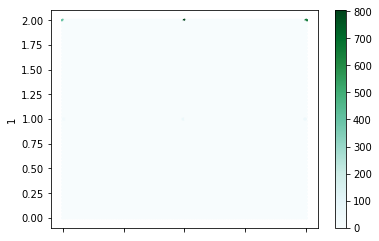

In [50]:
plt.figure();Y1.plot(x=0,y=1,kind="hexbin")

## Build classification battery

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import multiprocessing as mp
import time
import os
import random

seed = 7
random.seed(seed)
np.random.seed(seed)
# prepare models
models = []
models.append(("Dummy",DummyClassifier(strategy="most_frequent")))
#models.append(('LR', LogisticRegression(n_jobs=mp.cpu_count()-8,tol=0.1,class_weight="balanced",random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier(n_jobs=mp.cpu_count()-9,weights="distance")))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RF',RandomForestClassifier(max_depth=10, n_estimators=50, max_features=1,n_jobs=mp.cpu_count()-9,random_state=seed)))
#models.append(('SVM', LinearSVC(class_weight="balanced",random_state=seed)))
models.append(('MLP', MLPClassifier(solver='lbfgs', alpha=1e-5, 
                                   hidden_layer_sizes=(200,200,200,200,200), random_state=seed)))

In [155]:
X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, test_size=.15, random_state=42)

In [156]:
np.shape(X_train)
np.shape(Y_train)

(1612327,)

In [364]:
type(X_train)

NameError: name 'X_train' is not defined

In [157]:
#apply SMOTE oversampling of minority class to correct for imbalances in the data set
import imblearn.over_sampling
smote_sampler = imblearn.over_sampling.SMOTE(ratio="minority")
X_train,Y_train = smote_sampler.fit_sample(X_train,Y_train)

In [158]:
print(np.shape(X_train))
print(np.shape(Y_train))

(2172782, 700)
(2172782,)


In [ ]:
def test_model_battery(name,model,model_name):
    start_time = time.time()
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    label = list(set(Y_train))
    #a = f1_score(Y_test,Y_pred,average='weighted',labels=label)
    sc = f1_score(Y_test,Y_pred,average='weighted',labels=label)
    elapsed_time = time.time() - start_time
    
    with open(model_name+".txt", "a") as myfile:
        myfile.write(str(name)+" "+str(sc)+"\n")
    msg = "%s: %f " % (name, sc)
    print(msg)
    #print(f1_score(Y_test,Y_pred,average='weighted',labels=label))
    #print(Y_pred)
    print("calculated in: "+str(elapsed_time)+"s")

In [116]:
#test_model_battery(models[1][0],models[1][1],"test")
#list(set(Y_train))

LDA: 0.204559 
calculated in: 2.437760353088379s


In [ ]:
'_'.join(np.array(models)[:,0])

In [ ]:
from joblib import Parallel, delayed
model_name = "Regional_2m"
scoring = "f1"
try:
    os.remove(model_name+".txt")
except (FileNotFoundError):
    pass


if __name__ == '__main__':
    Parallel(n_jobs=9)(delayed(test_model_battery)(name,model,model_name) for name,model in models)


/home/servan/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dummy: 0.007855 
calculated in: 0.49235987663269043s
RF: 0.211390 
calculated in: 56.45842170715332s
NB: 0.157266 
calculated in: 206.35569977760315s
CART: 0.256660 
calculated in: 10005.960584402084s


In [ ]:
data = pd.read_csv(model_name+".txt", sep=" ", header=None)
data